In [1]:
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw_df = pd.read_json("polyrating.json",orient='columns')

def flatten(a):
    try:
        return a[0]
    except:
        return a
    
def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [2]:
raw_df1 = explode(raw_df,"reviews")
split_review = raw_df1["reviews"].apply(pd.Series)
df = raw_df1.join(split_review)

In [3]:
df = df.drop("reviews",axis=1)

## Cleaning

### Make rating numeric

In [4]:
df["agg_rating"] = pd.to_numeric(df["agg_rating"].str[:4], errors="coerce")

In [5]:
def get_course_num(course):
    if len(course) == 2:
        return course[1]
    else:
        return course

df["year"] = df["date"].str.extract('(\d+)')
df["month"] = df["date"].str[:3]
df["course_num"] = pd.to_numeric(df["class"].str.split("_").apply(get_course_num))
df["level"] = pd.to_numeric(df['course_num'].astype(str).str[0] + "00")

df = df[(df["course_num"] > 99) & (df["course_num"] < 551)]

## Average Grade by Year

In [6]:
df["gpa"] = df.grade.map({
    "A":4,
    "B":3,
    "C":2,
    "D":1,
    "F":0
})

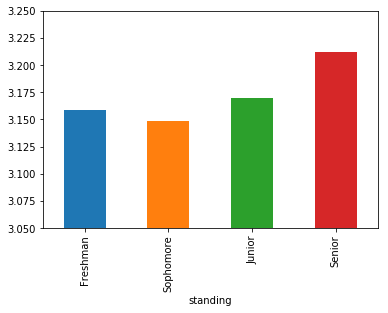

In [7]:
df.groupby("standing")["gpa"].mean()[["Freshman", "Sophomore", "Junior", "Senior"]].plot.bar(ylim=(3.05, 3.25))

## Average Rating of Professor by Year

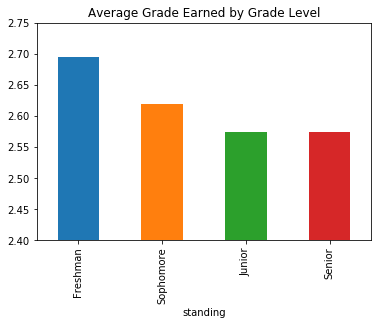

In [8]:
df.groupby("standing")["agg_rating"].mean()[["Freshman", "Sophomore", "Junior", "Senior"]].plot.bar(ylim=(2.4, 2.75), title="Average Grade Earned by Grade Level")

## Polyrating vs. Average Grade

In [9]:
profs = df["prof_name"].value_counts()[df["prof_name"].value_counts() > 30].to_frame().index.tolist()
high_rating_count = df[(df["prof_name"].isin(profs))]

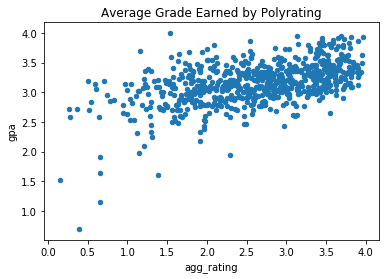

In [10]:
professor_means = high_rating_count.groupby("prof_name")[["agg_rating","gpa"]].mean()
high_rating_count.groupby("prof_name")[["agg_rating","gpa"]].mean().plot.scatter(x="agg_rating", y="gpa", title="Average Grade Earned by Polyrating")

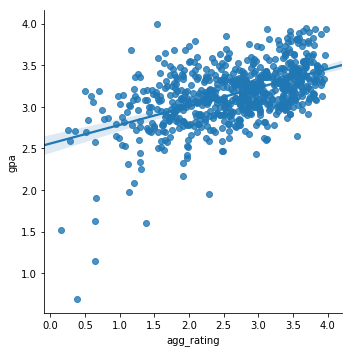

In [11]:
import seaborn as sns
import math

avg_rev_len = high_rating_count.groupby("prof_name")["review"].apply(lambda x: np.mean(x.str.len()))
professor_means["avg_rev_len"] = avg_rev_len
sns.lmplot(x="agg_rating", y="gpa", data=professor_means, fit_reg=True)
professor_means["log_transform"] = np.log(professor_means["avg_rev_len"])

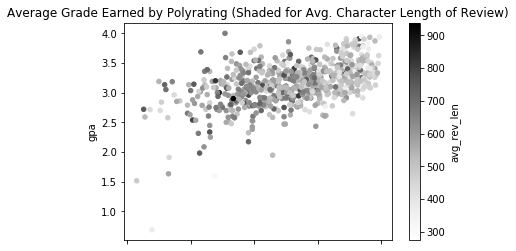

In [12]:
professor_means[professor_means["avg_rev_len"] < 1000].plot.scatter(x="agg_rating", y="gpa", c="avg_rev_len", title="Average Grade Earned by Polyrating (Shaded for Avg. Character Length of Review)")

## Avg. Grade by Course Type

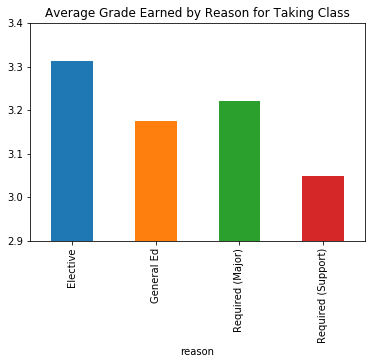

In [13]:
df.groupby("reason")["gpa"].mean().drop("N/A").plot.bar(ylim=(2.9, 3.4), title="Average Grade Earned by Reason for Taking Class")

## Avg. Grade by Year and Month

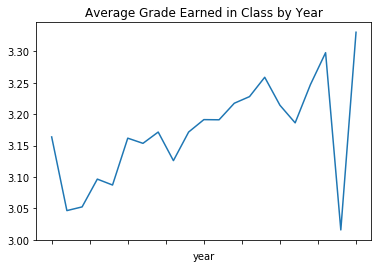

In [14]:
df.groupby("year")["gpa"].mean().plot(title="Average Grade Earned in Class by Year")

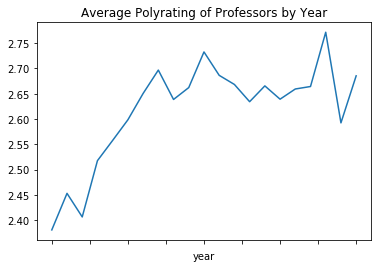

In [15]:
df.groupby("year")["agg_rating"].mean().plot(title="Average Polyrating of Professors by Year")

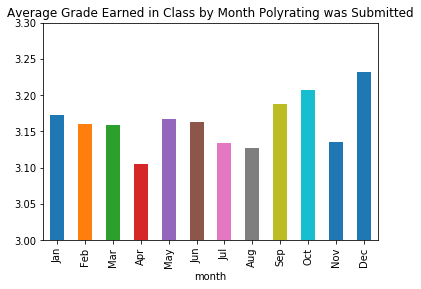

In [16]:
df.groupby("month")["gpa"].mean()[["Jan", "Feb", "Mar", "Apr","May", "Jun",
                                   "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]].plot.bar(ylim=(3, 3.3), title="Average Grade Earned in Class by Month Polyrating was Submitted")

## Average Grade by Course Level

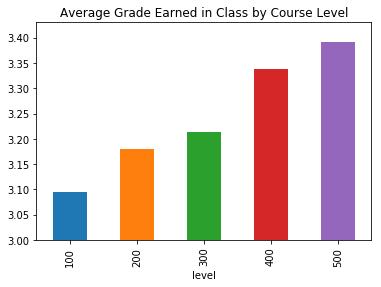

In [17]:
df.groupby("level")["gpa"].mean().plot.bar(ylim=(3, 3.43), title="Average Grade Earned in Class by Course Level")

## Polyrating by Keywords

In [18]:
df["awesome"] = df["review"].str.contains("awesome")
df["shit"] = df["review"].str.contains("shit")

awesome
False    2.602295
True     3.090410
Name: agg_rating, dtype: float64

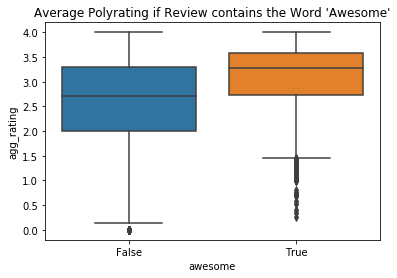

In [19]:
import seaborn as sns

sns.boxplot(x="awesome", y="agg_rating", data=df).set_title("Average Polyrating if Review contains the Word 'Awesome'")
df.groupby("awesome")["agg_rating"].mean()

shit
False    2.635707
True     2.358353
Name: agg_rating, dtype: float64

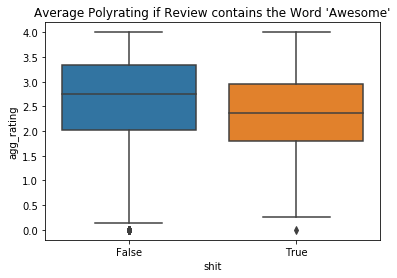

In [20]:
sns.boxplot(x="shit", y="agg_rating", data=df).set_title("Average Polyrating if Review contains the Word 'Awesome'")
df.groupby("shit")["agg_rating"].mean()

In [21]:
def gender_finder(review):
    m_total = 0
    m_total += review.lower().split().count("he")
    m_total += review.lower().split().count("his")    
    m_total += review.lower().split().count("him")    
    f_total = 0
    f_total += review.lower().split().count("she")    
    f_total += review.lower().split().count("her")    
    return m_total - f_total
    
df["gender"] = df["review"].apply(gender_finder)

In [22]:
profs_gend = df.groupby('prof_name')["gender"].sum().to_frame()

def determine_gend(num):
    if num > 0:
        return "male"
    elif num < 0:
        return "female"
    else:
        return "none"

In [23]:
def gender_getter(name, dict):
    return dict[name]

profs_gend["gend"] = profs_gend["gender"].apply(determine_gend)
profs_gend_dict = profs_gend.drop("gender", axis=1).to_dict()
df["genderr"] = df["prof_name"].apply(gender_getter(profs_gend_dict))

TypeError: gender_getter() missing 1 required positional argument: 'dict'

In [24]:
top_adj = ["helpful", "clear", "kind", "funny", "terrible", "confused", "happy", "enthusiastic", "excited",
          "sweet", "friendly", "wonderful", "perfect", "lazy", "frusterating", "fantastic", "arrogant",
           "condescending", "bored", "energetic", "dull", "odd", "strange", "sarcastic", "pleasant", "witty",
           "pompous", "creepy"]

In [43]:
listofadj = []
df_test = pd.DataFrame(columns=["prof_name","adjectives"])
for prof in df["prof_name"].unique():
    prof_sub = df[df["prof_name"] == prof]
    adj_dict = {}
    for adj in top_adj:
        adj_dict[adj] = 0
    for review in prof_sub["review"]:
        for word in review.lower().split():
            if word in top_adj:
                adj_dict[word] += 1
    df_test = df_test.append({"prof_name": prof,
                              "adjectives": adj_dict},
                              ignore_index=True)





In [56]:
df_test_adj = df_test["adjectives"].apply(pd.Series)
temp = df_test.join(df_test_adj).drop("adjectives",axis=1)
temp

#IF YOU WANT WITH POLYRATING COLLEGE
#pd.merge(df,temp,
#       on = "prof_name",
#       how = "left")

prof_name  helpful  clear  kind  funny  terrible  \
0              Abel, Christina        9      2     2      0         1   
1             Aberbromby, Kira        3      0     0      1         0   
2             abercromby, kira        0      0     1      0         1   
3                 Abitia, Fred        0      0     0      0         0   
4                  Abler, Fred        0      0     0      0         0   
5                 Abney, Keith        3      3     5      2         4   
6                   Abney, Ray        0      2     2      0         0   
7            Abshire, Franklin        0      0     0      0         0   
8               Acosta, Kellie        0      1     0      0         0   
9                 Adam, Sandra        3      0     0      0         0   
10                Adams, Nikki        1      1     0      0         0   
11             Adan, Elizabeth        2      1     3      0         0   
12                Agalos, Pete        1      0     1      2         0   
13                Agbo, Samuel        3      2     0      0         7   
14              Agrawal, Mohan        0      5     0      3         0   
15             Agronsky, Steve        9      5     2      6         0   
16    Aguayo-Vazquez, Jennifer        2      0     0      0         0   
17            Aguilera, Javier        5      3     3      0         2   
18                Ahern, James        2      1     2      0         1   
19              Ahler, Michael        0      0     0      0         0   
20         Ahlgren, William L.        2      2     3      1         2   
21                 Ahmed, Deif        0      0     0      0         0   
22       Ajaib, Muhammad Adeel        1      0     1      0         0   
23                Alaniz, Ryan        2      4     7      1         1   
24         Alexander, Benjamin        7      1     1      0         0   
25        Alexander, Charlotte        0      0     0      1         0   
26         Alexander, Dekhtyar        0      0     0      1         0   
27               Algert, Susan        1      0     0      0         0   
28            Allebe, Adrienne        0      0     0      0         0   
29              Allen, Regulus        0      2     1      0         0   
...                        ...      ...    ...   ...    ...       ...   
2424            York, Jonathan        0      0     0      0         0   
2425        Yoshimura, Michael        4      0     0      2         0   
2426     Yoshinobu, Stan Taira        1      1     0      0         0   
2427                Yost, Jenn        5      1     1      1         0   
2428             Young, Arthur        0      0     2      1         0   
2429                   Yu, Mei        4      0     0      0         0   
2430              Yu, Xiao-Hua        7      1     0      1         1   
2431                Yun, David        1      1     1      1         1   
2432           Zacarias, Hilda        1      0     0      0         0   
2433                 Zahn, Jan        5      1     0      2         0   
2434            Zahra, Alghoul        3      1     4      1         0   
2435         Zambrano, Eduardo        1      2     0      4         0   
2436            Zammit, Ronald       11      1     2      1         0   
2437         Zarowitz, Michael        2      0     1      1         0   
2438            Zatzick, Chris        0      1     2      0         0   
2439                 Zeng, Wei        1      0     1      0         0   
2440           Zetzsche, James        0      0     1      2         0   
2441        Zeuschner, Raymond        0      1     0      2         0   
2442               Zhang, Jane        0      0     1      0         0   
2443            Zhang, Jinsong        0      0     0      0         0   
2444               Zhang, Ning        2      1     1      1         0   
2445             Zhang, Shanju        3      2     2      3         0   
2446          Zhang, Xiaozheng        3      2     1      0         0   
2447  

In [31]:
(listofadj)

[{'Abel, Christina': {'helpful': 9,
   'clear': 2,
   'kind': 2,
   'funny': 0,
   'terrible': 1,
   'confused': 1,
   'happy': 2,
   'enthusiastic': 1,
   'excited': 0,
   'sweet': 1,
   'friendly': 1,
   'wonderful': 0,
   'perfect': 0,
   'lazy': 0,
   'frusterating': 0,
   'fantastic': 1,
   'arrogant': 0,
   'condescending': 0,
   'bored': 0,
   'energetic': 0,
   'dull': 0,
   'odd': 0,
   'strange': 0,
   'sarcastic': 0,
   'pleasant': 0,
   'witty': 0,
   'pompous': 0,
   'creepy': 0}},
 {'Aberbromby, Kira': {'helpful': 3,
   'clear': 0,
   'kind': 0,
   'funny': 1,
   'terrible': 0,
   'confused': 0,
   'happy': 1,
   'enthusiastic': 0,
   'excited': 0,
   'sweet': 0,
   'friendly': 0,
   'wonderful': 0,
   'perfect': 0,
   'lazy': 0,
   'frusterating': 0,
   'fantastic': 1,
   'arrogant': 0,
   'condescending': 0,
   'bored': 0,
   'energetic': 1,
   'dull': 0,
   'odd': 0,
   'strange': 0,
   'sarcastic': 0,
   'pleasant': 0,
   'witty': 0,
   'pompous': 0,
   'creepy': 0}},

In [ ]:
(df["prof_name"].unique())[5]

In [ ]:
df.head()

In [ ]:
df[df["prof_name"] == "Abney, Keith"]["adjectives"] = "test"